# Coding Exercise: Domain Adaption Meta Learning

For this tutorial, we will be showcasing use of Domain Adaption Meta Learning, to learn a simple curve of sinusoidal data. It's a variation of 'Model Agnostic Meta Learning', but with added prior information i.e; extra relevant information about domain is already added.

Let's Begin!!!!

#### Step 1: Import all libraries 

In [1]:
import math
import random
import torch # v0.4.1
from torch import nn
from torch.nn import functional as F
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

#### Step 2: Create a simple neural network architecture, which is going to learn the sinusoidal curve.
As mentioned above, we will be getting randomly generated data of sinusoidal curve so, we will be using this very small network, as we don't need a big one to learn a curve.

In [2]:
def net(x, params):
    x = F.linear(x, params[0], params[1])
    x1 = F.relu(x)

    x = F.linear(x1, params[2], params[3])
    x2 = F.relu(x)

    y = F.linear(x2, params[4], params[5])

    return y, x2, x1

params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

##### Step 3: Create another simple neural network architecture, for adding prior information about domain.
As mentioned above, we will be adding a prior knowledge to our main net. Therefore, we need to create a simple adap_net.

In [3]:
def adap_net(y, x2, x1, params):
    x = torch.cat([y, x2, x1], dim=1)

    x = F.linear(x, params[0], params[1])
    x = F.relu(x)

    x = F.linear(x, params[2], params[3])
    x = F.relu(x)

    x = F.linear(x, params[4], params[5])

    return x

adap_params = [
    torch.Tensor(32, 1+32+32).uniform_(-1./math.sqrt(65), 1./math.sqrt(65)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

#### step 4: set up parameters for training
so as we are going to use inner loop vs outer loop training as mentioned in DAML paper. thus, we need to set certain parameters such as alpha, beta, learning rate, optimizer, and number of loops. 

In [4]:
opt = torch.optim.SGD(params + adap_params, lr=1e-2)
n_inner_loop = 5
alpha = 3e-2

#### Step 5: Implement Optimization Algorithm 

In [5]:
inner_loop_loss=[]
outer_lopp_loss=[]

for it in range(100000):
    b = 0 if random.choice([True, False]) else math.pi
    
    #### Randomly obtain the task 2 sinusoidal data ####
    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(v_x + b)

    opt.zero_grad()

    new_params = params
    for k in range(n_inner_loop):
        f, f2, f1 = net(torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2) if b == 0 else random.uniform(-math.pi/2, -math.pi/4)]]), new_params)
        h = adap_net(f, f2, f1, adap_params)
        adap_loss = F.l1_loss(h, torch.zeros(1, 1))

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(adap_loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

        if it % 100 == 0: 
            inner_loop_loss.append(adap_loss)
            print ('Iteration %d -- Inner loop %d -- Loss: %.4f' % (it, k, adap_loss))

    v_f, _, _ = net(v_x, new_params)
    loss = F.l1_loss(v_f, v_y)
    loss.backward()

    opt.step()

    if it % 100 == 0: 
        outer_lopp_loss.append(loss)
        print ('Iteration %d -- Outer Loss: %.4f' % (it, loss))


Iteration 0 -- Inner loop 0 -- Loss: 0.0211
Iteration 0 -- Inner loop 1 -- Loss: 0.0183
Iteration 0 -- Inner loop 2 -- Loss: 0.0225
Iteration 0 -- Inner loop 3 -- Loss: 0.0180
Iteration 0 -- Inner loop 4 -- Loss: 0.0156
Iteration 0 -- Outer Loss: 0.5667
Iteration 100 -- Inner loop 0 -- Loss: 0.0009
Iteration 100 -- Inner loop 1 -- Loss: 0.0007
Iteration 100 -- Inner loop 2 -- Loss: 0.0003
Iteration 100 -- Inner loop 3 -- Loss: 0.0003
Iteration 100 -- Inner loop 4 -- Loss: 0.0000
Iteration 100 -- Outer Loss: 0.8096
Iteration 200 -- Inner loop 0 -- Loss: 0.0078
Iteration 200 -- Inner loop 1 -- Loss: 0.0033
Iteration 200 -- Inner loop 2 -- Loss: 0.0064
Iteration 200 -- Inner loop 3 -- Loss: 0.0034
Iteration 200 -- Inner loop 4 -- Loss: 0.0034
Iteration 200 -- Outer Loss: 0.7044
Iteration 300 -- Inner loop 0 -- Loss: 0.0009
Iteration 300 -- Inner loop 1 -- Loss: 0.0003
Iteration 300 -- Inner loop 2 -- Loss: 0.0005
Iteration 300 -- Inner loop 3 -- Loss: 0.0003
Iteration 300 -- Inner loop 4 

Iteration 3100 -- Inner loop 0 -- Loss: 0.0081
Iteration 3100 -- Inner loop 1 -- Loss: 0.0063
Iteration 3100 -- Inner loop 2 -- Loss: 0.0061
Iteration 3100 -- Inner loop 3 -- Loss: 0.0055
Iteration 3100 -- Inner loop 4 -- Loss: 0.0054
Iteration 3100 -- Outer Loss: 0.7374
Iteration 3200 -- Inner loop 0 -- Loss: 0.0173
Iteration 3200 -- Inner loop 1 -- Loss: 0.0151
Iteration 3200 -- Inner loop 2 -- Loss: 0.0075
Iteration 3200 -- Inner loop 3 -- Loss: 0.0131
Iteration 3200 -- Inner loop 4 -- Loss: 0.0100
Iteration 3200 -- Outer Loss: 0.4972
Iteration 3300 -- Inner loop 0 -- Loss: 0.0122
Iteration 3300 -- Inner loop 1 -- Loss: 0.0099
Iteration 3300 -- Inner loop 2 -- Loss: 0.0077
Iteration 3300 -- Inner loop 3 -- Loss: 0.0059
Iteration 3300 -- Inner loop 4 -- Loss: 0.0072
Iteration 3300 -- Outer Loss: 0.5285
Iteration 3400 -- Inner loop 0 -- Loss: 0.0090
Iteration 3400 -- Inner loop 1 -- Loss: 0.0089
Iteration 3400 -- Inner loop 2 -- Loss: 0.0067
Iteration 3400 -- Inner loop 3 -- Loss: 0.0

Iteration 6200 -- Inner loop 0 -- Loss: 0.0294
Iteration 6200 -- Inner loop 1 -- Loss: 0.0259
Iteration 6200 -- Inner loop 2 -- Loss: 0.0365
Iteration 6200 -- Inner loop 3 -- Loss: 0.0304
Iteration 6200 -- Inner loop 4 -- Loss: 0.0352
Iteration 6200 -- Outer Loss: 0.4244
Iteration 6300 -- Inner loop 0 -- Loss: 0.0672
Iteration 6300 -- Inner loop 1 -- Loss: 0.0711
Iteration 6300 -- Inner loop 2 -- Loss: 0.0646
Iteration 6300 -- Inner loop 3 -- Loss: 0.0737
Iteration 6300 -- Inner loop 4 -- Loss: 0.0644
Iteration 6300 -- Outer Loss: 0.9264
Iteration 6400 -- Inner loop 0 -- Loss: 0.0466
Iteration 6400 -- Inner loop 1 -- Loss: 0.0468
Iteration 6400 -- Inner loop 2 -- Loss: 0.0702
Iteration 6400 -- Inner loop 3 -- Loss: 0.0448
Iteration 6400 -- Inner loop 4 -- Loss: 0.0681
Iteration 6400 -- Outer Loss: 0.5050
Iteration 6500 -- Inner loop 0 -- Loss: 0.0343
Iteration 6500 -- Inner loop 1 -- Loss: 0.0350
Iteration 6500 -- Inner loop 2 -- Loss: 0.0387
Iteration 6500 -- Inner loop 3 -- Loss: 0.0

Iteration 9300 -- Inner loop 0 -- Loss: 0.1066
Iteration 9300 -- Inner loop 1 -- Loss: 0.0824
Iteration 9300 -- Inner loop 2 -- Loss: 0.0791
Iteration 9300 -- Inner loop 3 -- Loss: 0.1000
Iteration 9300 -- Inner loop 4 -- Loss: 0.1088
Iteration 9300 -- Outer Loss: 0.6639
Iteration 9400 -- Inner loop 0 -- Loss: 0.0917
Iteration 9400 -- Inner loop 1 -- Loss: 0.0766
Iteration 9400 -- Inner loop 2 -- Loss: 0.0956
Iteration 9400 -- Inner loop 3 -- Loss: 0.0700
Iteration 9400 -- Inner loop 4 -- Loss: 0.0696
Iteration 9400 -- Outer Loss: 0.8474
Iteration 9500 -- Inner loop 0 -- Loss: 0.0571
Iteration 9500 -- Inner loop 1 -- Loss: 0.0547
Iteration 9500 -- Inner loop 2 -- Loss: 0.0533
Iteration 9500 -- Inner loop 3 -- Loss: 0.0525
Iteration 9500 -- Inner loop 4 -- Loss: 0.0512
Iteration 9500 -- Outer Loss: 0.7302
Iteration 9600 -- Inner loop 0 -- Loss: 0.0589
Iteration 9600 -- Inner loop 1 -- Loss: 0.0552
Iteration 9600 -- Inner loop 2 -- Loss: 0.0489
Iteration 9600 -- Inner loop 3 -- Loss: 0.0

Iteration 12300 -- Inner loop 0 -- Loss: 0.6127
Iteration 12300 -- Inner loop 1 -- Loss: 0.4777
Iteration 12300 -- Inner loop 2 -- Loss: 0.3039
Iteration 12300 -- Inner loop 3 -- Loss: 0.0058
Iteration 12300 -- Inner loop 4 -- Loss: 0.0802
Iteration 12300 -- Outer Loss: 0.6063
Iteration 12400 -- Inner loop 0 -- Loss: 0.6783
Iteration 12400 -- Inner loop 1 -- Loss: 0.4221
Iteration 12400 -- Inner loop 2 -- Loss: 0.0024
Iteration 12400 -- Inner loop 3 -- Loss: 0.3891
Iteration 12400 -- Inner loop 4 -- Loss: 0.0291
Iteration 12400 -- Outer Loss: 0.2486
Iteration 12500 -- Inner loop 0 -- Loss: 0.6947
Iteration 12500 -- Inner loop 1 -- Loss: 0.2655
Iteration 12500 -- Inner loop 2 -- Loss: 0.0248
Iteration 12500 -- Inner loop 3 -- Loss: 0.0218
Iteration 12500 -- Inner loop 4 -- Loss: 0.2059
Iteration 12500 -- Outer Loss: 0.4936
Iteration 12600 -- Inner loop 0 -- Loss: 1.0303
Iteration 12600 -- Inner loop 1 -- Loss: 0.6181
Iteration 12600 -- Inner loop 2 -- Loss: 0.4471
Iteration 12600 -- Inn

Iteration 15300 -- Inner loop 0 -- Loss: 2.9300
Iteration 15300 -- Inner loop 1 -- Loss: 1.6844
Iteration 15300 -- Inner loop 2 -- Loss: 0.3305
Iteration 15300 -- Inner loop 3 -- Loss: 0.0579
Iteration 15300 -- Inner loop 4 -- Loss: 0.0353
Iteration 15300 -- Outer Loss: 0.2531
Iteration 15400 -- Inner loop 0 -- Loss: 2.7191
Iteration 15400 -- Inner loop 1 -- Loss: 1.8523
Iteration 15400 -- Inner loop 2 -- Loss: 1.2259
Iteration 15400 -- Inner loop 3 -- Loss: 0.4161
Iteration 15400 -- Inner loop 4 -- Loss: 0.1764
Iteration 15400 -- Outer Loss: 0.2843
Iteration 15500 -- Inner loop 0 -- Loss: 3.0314
Iteration 15500 -- Inner loop 1 -- Loss: 1.9446
Iteration 15500 -- Inner loop 2 -- Loss: 1.3714
Iteration 15500 -- Inner loop 3 -- Loss: 0.3123
Iteration 15500 -- Inner loop 4 -- Loss: 0.0775
Iteration 15500 -- Outer Loss: 0.4831
Iteration 15600 -- Inner loop 0 -- Loss: 2.6742
Iteration 15600 -- Inner loop 1 -- Loss: 1.7360
Iteration 15600 -- Inner loop 2 -- Loss: 0.7921
Iteration 15600 -- Inn

Iteration 18300 -- Inner loop 0 -- Loss: 3.7418
Iteration 18300 -- Inner loop 1 -- Loss: 2.4586
Iteration 18300 -- Inner loop 2 -- Loss: 1.4917
Iteration 18300 -- Inner loop 3 -- Loss: 0.8135
Iteration 18300 -- Inner loop 4 -- Loss: 0.1223
Iteration 18300 -- Outer Loss: 0.1473
Iteration 18400 -- Inner loop 0 -- Loss: 4.6349
Iteration 18400 -- Inner loop 1 -- Loss: 1.9135
Iteration 18400 -- Inner loop 2 -- Loss: 0.3942
Iteration 18400 -- Inner loop 3 -- Loss: 0.1418
Iteration 18400 -- Inner loop 4 -- Loss: 0.3472
Iteration 18400 -- Outer Loss: 0.1961
Iteration 18500 -- Inner loop 0 -- Loss: 3.6584
Iteration 18500 -- Inner loop 1 -- Loss: 2.7500
Iteration 18500 -- Inner loop 2 -- Loss: 1.9575
Iteration 18500 -- Inner loop 3 -- Loss: 0.9271
Iteration 18500 -- Inner loop 4 -- Loss: 0.3239
Iteration 18500 -- Outer Loss: 0.0463
Iteration 18600 -- Inner loop 0 -- Loss: 3.6891
Iteration 18600 -- Inner loop 1 -- Loss: 2.8806
Iteration 18600 -- Inner loop 2 -- Loss: 1.7749
Iteration 18600 -- Inn

Iteration 21300 -- Inner loop 0 -- Loss: 4.8261
Iteration 21300 -- Inner loop 1 -- Loss: 3.0377
Iteration 21300 -- Inner loop 2 -- Loss: 1.5388
Iteration 21300 -- Inner loop 3 -- Loss: 0.7053
Iteration 21300 -- Inner loop 4 -- Loss: 0.1605
Iteration 21300 -- Outer Loss: 0.2452
Iteration 21400 -- Inner loop 0 -- Loss: 4.5205
Iteration 21400 -- Inner loop 1 -- Loss: 3.4638
Iteration 21400 -- Inner loop 2 -- Loss: 1.4505
Iteration 21400 -- Inner loop 3 -- Loss: 0.8071
Iteration 21400 -- Inner loop 4 -- Loss: 0.5042
Iteration 21400 -- Outer Loss: 0.0451
Iteration 21500 -- Inner loop 0 -- Loss: 3.9768
Iteration 21500 -- Inner loop 1 -- Loss: 2.9294
Iteration 21500 -- Inner loop 2 -- Loss: 1.8645
Iteration 21500 -- Inner loop 3 -- Loss: 1.3624
Iteration 21500 -- Inner loop 4 -- Loss: 0.9634
Iteration 21500 -- Outer Loss: 0.4005
Iteration 21600 -- Inner loop 0 -- Loss: 5.0283
Iteration 21600 -- Inner loop 1 -- Loss: 2.6847
Iteration 21600 -- Inner loop 2 -- Loss: 1.1545
Iteration 21600 -- Inn

Iteration 24300 -- Inner loop 0 -- Loss: 4.7633
Iteration 24300 -- Inner loop 1 -- Loss: 2.7185
Iteration 24300 -- Inner loop 2 -- Loss: 1.7129
Iteration 24300 -- Inner loop 3 -- Loss: 1.0175
Iteration 24300 -- Inner loop 4 -- Loss: 0.1368
Iteration 24300 -- Outer Loss: 0.1649
Iteration 24400 -- Inner loop 0 -- Loss: 4.8126
Iteration 24400 -- Inner loop 1 -- Loss: 3.2009
Iteration 24400 -- Inner loop 2 -- Loss: 1.0733
Iteration 24400 -- Inner loop 3 -- Loss: 0.2572
Iteration 24400 -- Inner loop 4 -- Loss: 0.1814
Iteration 24400 -- Outer Loss: 0.0548
Iteration 24500 -- Inner loop 0 -- Loss: 5.2730
Iteration 24500 -- Inner loop 1 -- Loss: 2.6139
Iteration 24500 -- Inner loop 2 -- Loss: 1.0738
Iteration 24500 -- Inner loop 3 -- Loss: 0.4051
Iteration 24500 -- Inner loop 4 -- Loss: 0.2711
Iteration 24500 -- Outer Loss: 0.0804
Iteration 24600 -- Inner loop 0 -- Loss: 5.4429
Iteration 24600 -- Inner loop 1 -- Loss: 2.1438
Iteration 24600 -- Inner loop 2 -- Loss: 1.3035
Iteration 24600 -- Inn

Iteration 27300 -- Inner loop 0 -- Loss: 6.1259
Iteration 27300 -- Inner loop 1 -- Loss: 2.6541
Iteration 27300 -- Inner loop 2 -- Loss: 0.9556
Iteration 27300 -- Inner loop 3 -- Loss: 0.5596
Iteration 27300 -- Inner loop 4 -- Loss: 0.0806
Iteration 27300 -- Outer Loss: 0.1968
Iteration 27400 -- Inner loop 0 -- Loss: 5.5119
Iteration 27400 -- Inner loop 1 -- Loss: 2.4481
Iteration 27400 -- Inner loop 2 -- Loss: 0.9393
Iteration 27400 -- Inner loop 3 -- Loss: 0.5335
Iteration 27400 -- Inner loop 4 -- Loss: 0.2132
Iteration 27400 -- Outer Loss: 0.1128
Iteration 27500 -- Inner loop 0 -- Loss: 5.5533
Iteration 27500 -- Inner loop 1 -- Loss: 1.9700
Iteration 27500 -- Inner loop 2 -- Loss: 0.6044
Iteration 27500 -- Inner loop 3 -- Loss: 0.0074
Iteration 27500 -- Inner loop 4 -- Loss: 0.0051
Iteration 27500 -- Outer Loss: 0.0470
Iteration 27600 -- Inner loop 0 -- Loss: 6.1334
Iteration 27600 -- Inner loop 1 -- Loss: 2.2947
Iteration 27600 -- Inner loop 2 -- Loss: 1.3077
Iteration 27600 -- Inn

Iteration 30300 -- Inner loop 0 -- Loss: 5.4170
Iteration 30300 -- Inner loop 1 -- Loss: 2.5801
Iteration 30300 -- Inner loop 2 -- Loss: 0.5665
Iteration 30300 -- Inner loop 3 -- Loss: 0.0011
Iteration 30300 -- Inner loop 4 -- Loss: 0.0695
Iteration 30300 -- Outer Loss: 0.3307
Iteration 30400 -- Inner loop 0 -- Loss: 5.3883
Iteration 30400 -- Inner loop 1 -- Loss: 3.0267
Iteration 30400 -- Inner loop 2 -- Loss: 0.7045
Iteration 30400 -- Inner loop 3 -- Loss: 0.2495
Iteration 30400 -- Inner loop 4 -- Loss: 0.0219
Iteration 30400 -- Outer Loss: 0.0740
Iteration 30500 -- Inner loop 0 -- Loss: 5.1226
Iteration 30500 -- Inner loop 1 -- Loss: 3.2370
Iteration 30500 -- Inner loop 2 -- Loss: 0.3561
Iteration 30500 -- Inner loop 3 -- Loss: 0.1074
Iteration 30500 -- Inner loop 4 -- Loss: 0.1213
Iteration 30500 -- Outer Loss: 0.1075
Iteration 30600 -- Inner loop 0 -- Loss: 6.8951
Iteration 30600 -- Inner loop 1 -- Loss: 1.8605
Iteration 30600 -- Inner loop 2 -- Loss: 0.1140
Iteration 30600 -- Inn

Iteration 33300 -- Inner loop 0 -- Loss: 6.8382
Iteration 33300 -- Inner loop 1 -- Loss: 1.7140
Iteration 33300 -- Inner loop 2 -- Loss: 0.0112
Iteration 33300 -- Inner loop 3 -- Loss: 0.0114
Iteration 33300 -- Inner loop 4 -- Loss: 0.0106
Iteration 33300 -- Outer Loss: 0.1790
Iteration 33400 -- Inner loop 0 -- Loss: 6.0129
Iteration 33400 -- Inner loop 1 -- Loss: 1.9104
Iteration 33400 -- Inner loop 2 -- Loss: 0.0087
Iteration 33400 -- Inner loop 3 -- Loss: 0.0159
Iteration 33400 -- Inner loop 4 -- Loss: 0.0071
Iteration 33400 -- Outer Loss: 0.1982
Iteration 33500 -- Inner loop 0 -- Loss: 5.7610
Iteration 33500 -- Inner loop 1 -- Loss: 2.6302
Iteration 33500 -- Inner loop 2 -- Loss: 0.0072
Iteration 33500 -- Inner loop 3 -- Loss: 0.0078
Iteration 33500 -- Inner loop 4 -- Loss: 0.0072
Iteration 33500 -- Outer Loss: 0.2498
Iteration 33600 -- Inner loop 0 -- Loss: 5.9011
Iteration 33600 -- Inner loop 1 -- Loss: 2.9118
Iteration 33600 -- Inner loop 2 -- Loss: 0.0097
Iteration 33600 -- Inn

Iteration 36300 -- Inner loop 0 -- Loss: 6.2993
Iteration 36300 -- Inner loop 1 -- Loss: 1.6367
Iteration 36300 -- Inner loop 2 -- Loss: 0.0081
Iteration 36300 -- Inner loop 3 -- Loss: 0.0084
Iteration 36300 -- Inner loop 4 -- Loss: 0.0081
Iteration 36300 -- Outer Loss: 0.1030
Iteration 36400 -- Inner loop 0 -- Loss: 6.8000
Iteration 36400 -- Inner loop 1 -- Loss: 0.7179
Iteration 36400 -- Inner loop 2 -- Loss: 0.0118
Iteration 36400 -- Inner loop 3 -- Loss: 0.0087
Iteration 36400 -- Inner loop 4 -- Loss: 0.0107
Iteration 36400 -- Outer Loss: 0.1364
Iteration 36500 -- Inner loop 0 -- Loss: 7.3559
Iteration 36500 -- Inner loop 1 -- Loss: 1.7540
Iteration 36500 -- Inner loop 2 -- Loss: 0.0046
Iteration 36500 -- Inner loop 3 -- Loss: 0.0044
Iteration 36500 -- Inner loop 4 -- Loss: 0.0014
Iteration 36500 -- Outer Loss: 0.1068
Iteration 36600 -- Inner loop 0 -- Loss: 6.7009
Iteration 36600 -- Inner loop 1 -- Loss: 0.8266
Iteration 36600 -- Inner loop 2 -- Loss: 0.0075
Iteration 36600 -- Inn

Iteration 39300 -- Inner loop 0 -- Loss: 7.6187
Iteration 39300 -- Inner loop 1 -- Loss: 0.6390
Iteration 39300 -- Inner loop 2 -- Loss: 0.0094
Iteration 39300 -- Inner loop 3 -- Loss: 0.0026
Iteration 39300 -- Inner loop 4 -- Loss: 0.0093
Iteration 39300 -- Outer Loss: 0.3050
Iteration 39400 -- Inner loop 0 -- Loss: 7.8505
Iteration 39400 -- Inner loop 1 -- Loss: 0.1119
Iteration 39400 -- Inner loop 2 -- Loss: 0.0163
Iteration 39400 -- Inner loop 3 -- Loss: 0.0163
Iteration 39400 -- Inner loop 4 -- Loss: 0.0158
Iteration 39400 -- Outer Loss: 0.0782
Iteration 39500 -- Inner loop 0 -- Loss: 8.1824
Iteration 39500 -- Inner loop 1 -- Loss: 0.7787
Iteration 39500 -- Inner loop 2 -- Loss: 0.0006
Iteration 39500 -- Inner loop 3 -- Loss: 0.0064
Iteration 39500 -- Inner loop 4 -- Loss: 0.0035
Iteration 39500 -- Outer Loss: 0.0904
Iteration 39600 -- Inner loop 0 -- Loss: 8.8419
Iteration 39600 -- Inner loop 1 -- Loss: 0.9289
Iteration 39600 -- Inner loop 2 -- Loss: 0.0079
Iteration 39600 -- Inn

Iteration 42300 -- Inner loop 0 -- Loss: 8.4844
Iteration 42300 -- Inner loop 1 -- Loss: 0.0095
Iteration 42300 -- Inner loop 2 -- Loss: 0.0119
Iteration 42300 -- Inner loop 3 -- Loss: 0.0089
Iteration 42300 -- Inner loop 4 -- Loss: 0.0084
Iteration 42300 -- Outer Loss: 0.0254
Iteration 42400 -- Inner loop 0 -- Loss: 10.3129
Iteration 42400 -- Inner loop 1 -- Loss: 0.0067
Iteration 42400 -- Inner loop 2 -- Loss: 0.0060
Iteration 42400 -- Inner loop 3 -- Loss: 0.0059
Iteration 42400 -- Inner loop 4 -- Loss: 0.0046
Iteration 42400 -- Outer Loss: 0.0807
Iteration 42500 -- Inner loop 0 -- Loss: 10.9679
Iteration 42500 -- Inner loop 1 -- Loss: 0.0098
Iteration 42500 -- Inner loop 2 -- Loss: 0.0092
Iteration 42500 -- Inner loop 3 -- Loss: 0.0087
Iteration 42500 -- Inner loop 4 -- Loss: 0.0080
Iteration 42500 -- Outer Loss: 0.0522
Iteration 42600 -- Inner loop 0 -- Loss: 9.5814
Iteration 42600 -- Inner loop 1 -- Loss: 0.0067
Iteration 42600 -- Inner loop 2 -- Loss: 0.0012
Iteration 42600 -- I

Iteration 45300 -- Inner loop 0 -- Loss: 11.4828
Iteration 45300 -- Inner loop 1 -- Loss: 0.0061
Iteration 45300 -- Inner loop 2 -- Loss: 0.0002
Iteration 45300 -- Inner loop 3 -- Loss: 0.0032
Iteration 45300 -- Inner loop 4 -- Loss: 0.0116
Iteration 45300 -- Outer Loss: 0.0487
Iteration 45400 -- Inner loop 0 -- Loss: 9.2863
Iteration 45400 -- Inner loop 1 -- Loss: 0.0065
Iteration 45400 -- Inner loop 2 -- Loss: 0.0034
Iteration 45400 -- Inner loop 3 -- Loss: 0.0004
Iteration 45400 -- Inner loop 4 -- Loss: 0.0049
Iteration 45400 -- Outer Loss: 0.1481
Iteration 45500 -- Inner loop 0 -- Loss: 10.5192
Iteration 45500 -- Inner loop 1 -- Loss: 0.0012
Iteration 45500 -- Inner loop 2 -- Loss: 0.0009
Iteration 45500 -- Inner loop 3 -- Loss: 0.0011
Iteration 45500 -- Inner loop 4 -- Loss: 0.0008
Iteration 45500 -- Outer Loss: 0.0267
Iteration 45600 -- Inner loop 0 -- Loss: 11.7433
Iteration 45600 -- Inner loop 1 -- Loss: 0.0005
Iteration 45600 -- Inner loop 2 -- Loss: 0.0038
Iteration 45600 -- 

Iteration 48300 -- Inner loop 0 -- Loss: 10.7847
Iteration 48300 -- Inner loop 1 -- Loss: 0.0083
Iteration 48300 -- Inner loop 2 -- Loss: 0.0008
Iteration 48300 -- Inner loop 3 -- Loss: 0.0010
Iteration 48300 -- Inner loop 4 -- Loss: 0.0005
Iteration 48300 -- Outer Loss: 0.1075
Iteration 48400 -- Inner loop 0 -- Loss: 11.2425
Iteration 48400 -- Inner loop 1 -- Loss: 0.0125
Iteration 48400 -- Inner loop 2 -- Loss: 0.0113
Iteration 48400 -- Inner loop 3 -- Loss: 0.0012
Iteration 48400 -- Inner loop 4 -- Loss: 0.0012
Iteration 48400 -- Outer Loss: 0.1016
Iteration 48500 -- Inner loop 0 -- Loss: 11.2217
Iteration 48500 -- Inner loop 1 -- Loss: 0.0053
Iteration 48500 -- Inner loop 2 -- Loss: 0.0148
Iteration 48500 -- Inner loop 3 -- Loss: 0.0111
Iteration 48500 -- Inner loop 4 -- Loss: 0.0034
Iteration 48500 -- Outer Loss: 0.1244
Iteration 48600 -- Inner loop 0 -- Loss: 11.9168
Iteration 48600 -- Inner loop 1 -- Loss: 0.0042
Iteration 48600 -- Inner loop 2 -- Loss: 0.0135
Iteration 48600 --

Iteration 51300 -- Inner loop 0 -- Loss: 9.2820
Iteration 51300 -- Inner loop 1 -- Loss: 0.0299
Iteration 51300 -- Inner loop 2 -- Loss: 0.0262
Iteration 51300 -- Inner loop 3 -- Loss: 0.0192
Iteration 51300 -- Inner loop 4 -- Loss: 0.0384
Iteration 51300 -- Outer Loss: 0.0747
Iteration 51400 -- Inner loop 0 -- Loss: 8.9255
Iteration 51400 -- Inner loop 1 -- Loss: 0.0046
Iteration 51400 -- Inner loop 2 -- Loss: 0.0049
Iteration 51400 -- Inner loop 3 -- Loss: 0.0089
Iteration 51400 -- Inner loop 4 -- Loss: 0.0049
Iteration 51400 -- Outer Loss: 0.0677
Iteration 51500 -- Inner loop 0 -- Loss: 9.3109
Iteration 51500 -- Inner loop 1 -- Loss: 0.0310
Iteration 51500 -- Inner loop 2 -- Loss: 0.0210
Iteration 51500 -- Inner loop 3 -- Loss: 0.0303
Iteration 51500 -- Inner loop 4 -- Loss: 0.0297
Iteration 51500 -- Outer Loss: 0.0148
Iteration 51600 -- Inner loop 0 -- Loss: 8.5458
Iteration 51600 -- Inner loop 1 -- Loss: 0.0229
Iteration 51600 -- Inner loop 2 -- Loss: 0.0147
Iteration 51600 -- Inn

Iteration 54300 -- Inner loop 0 -- Loss: 8.9786
Iteration 54300 -- Inner loop 1 -- Loss: 0.0054
Iteration 54300 -- Inner loop 2 -- Loss: 0.0060
Iteration 54300 -- Inner loop 3 -- Loss: 0.0067
Iteration 54300 -- Inner loop 4 -- Loss: 0.0104
Iteration 54300 -- Outer Loss: 0.0451
Iteration 54400 -- Inner loop 0 -- Loss: 8.9209
Iteration 54400 -- Inner loop 1 -- Loss: 0.0010
Iteration 54400 -- Inner loop 2 -- Loss: 0.0115
Iteration 54400 -- Inner loop 3 -- Loss: 0.0153
Iteration 54400 -- Inner loop 4 -- Loss: 0.0054
Iteration 54400 -- Outer Loss: 0.0422
Iteration 54500 -- Inner loop 0 -- Loss: 9.1407
Iteration 54500 -- Inner loop 1 -- Loss: 0.0070
Iteration 54500 -- Inner loop 2 -- Loss: 0.0188
Iteration 54500 -- Inner loop 3 -- Loss: 0.0276
Iteration 54500 -- Inner loop 4 -- Loss: 0.0019
Iteration 54500 -- Outer Loss: 0.0462
Iteration 54600 -- Inner loop 0 -- Loss: 8.2647
Iteration 54600 -- Inner loop 1 -- Loss: 0.0093
Iteration 54600 -- Inner loop 2 -- Loss: 0.0054
Iteration 54600 -- Inn

Iteration 57300 -- Inner loop 0 -- Loss: 10.1602
Iteration 57300 -- Inner loop 1 -- Loss: 0.0484
Iteration 57300 -- Inner loop 2 -- Loss: 0.0220
Iteration 57300 -- Inner loop 3 -- Loss: 0.0369
Iteration 57300 -- Inner loop 4 -- Loss: 0.0568
Iteration 57300 -- Outer Loss: 0.0423
Iteration 57400 -- Inner loop 0 -- Loss: 8.4894
Iteration 57400 -- Inner loop 1 -- Loss: 0.0259
Iteration 57400 -- Inner loop 2 -- Loss: 0.0176
Iteration 57400 -- Inner loop 3 -- Loss: 0.0248
Iteration 57400 -- Inner loop 4 -- Loss: 0.0161
Iteration 57400 -- Outer Loss: 0.0675
Iteration 57500 -- Inner loop 0 -- Loss: 8.6707
Iteration 57500 -- Inner loop 1 -- Loss: 0.0115
Iteration 57500 -- Inner loop 2 -- Loss: 0.0266
Iteration 57500 -- Inner loop 3 -- Loss: 0.0108
Iteration 57500 -- Inner loop 4 -- Loss: 0.0153
Iteration 57500 -- Outer Loss: 0.0333
Iteration 57600 -- Inner loop 0 -- Loss: 12.4608
Iteration 57600 -- Inner loop 1 -- Loss: 0.0144
Iteration 57600 -- Inner loop 2 -- Loss: 0.0302
Iteration 57600 -- I

Iteration 60300 -- Inner loop 0 -- Loss: 11.0546
Iteration 60300 -- Inner loop 1 -- Loss: 0.0136
Iteration 60300 -- Inner loop 2 -- Loss: 0.0184
Iteration 60300 -- Inner loop 3 -- Loss: 0.0091
Iteration 60300 -- Inner loop 4 -- Loss: 0.0124
Iteration 60300 -- Outer Loss: 0.0756
Iteration 60400 -- Inner loop 0 -- Loss: 8.4870
Iteration 60400 -- Inner loop 1 -- Loss: 0.0017
Iteration 60400 -- Inner loop 2 -- Loss: 0.0068
Iteration 60400 -- Inner loop 3 -- Loss: 0.0014
Iteration 60400 -- Inner loop 4 -- Loss: 0.0003
Iteration 60400 -- Outer Loss: 0.0372
Iteration 60500 -- Inner loop 0 -- Loss: 10.8388
Iteration 60500 -- Inner loop 1 -- Loss: 0.0178
Iteration 60500 -- Inner loop 2 -- Loss: 0.0129
Iteration 60500 -- Inner loop 3 -- Loss: 0.0064
Iteration 60500 -- Inner loop 4 -- Loss: 0.0040
Iteration 60500 -- Outer Loss: 0.0767
Iteration 60600 -- Inner loop 0 -- Loss: 9.6960
Iteration 60600 -- Inner loop 1 -- Loss: 0.0248
Iteration 60600 -- Inner loop 2 -- Loss: 0.0091
Iteration 60600 -- I

Iteration 63300 -- Inner loop 0 -- Loss: 9.0359
Iteration 63300 -- Inner loop 1 -- Loss: 0.0077
Iteration 63300 -- Inner loop 2 -- Loss: 0.0066
Iteration 63300 -- Inner loop 3 -- Loss: 0.0185
Iteration 63300 -- Inner loop 4 -- Loss: 0.0226
Iteration 63300 -- Outer Loss: 0.1345
Iteration 63400 -- Inner loop 0 -- Loss: 8.1063
Iteration 63400 -- Inner loop 1 -- Loss: 0.0148
Iteration 63400 -- Inner loop 2 -- Loss: 0.0078
Iteration 63400 -- Inner loop 3 -- Loss: 0.0013
Iteration 63400 -- Inner loop 4 -- Loss: 0.0048
Iteration 63400 -- Outer Loss: 0.0928
Iteration 63500 -- Inner loop 0 -- Loss: 7.9787
Iteration 63500 -- Inner loop 1 -- Loss: 0.0068
Iteration 63500 -- Inner loop 2 -- Loss: 0.0105
Iteration 63500 -- Inner loop 3 -- Loss: 0.0028
Iteration 63500 -- Inner loop 4 -- Loss: 0.0003
Iteration 63500 -- Outer Loss: 0.1074
Iteration 63600 -- Inner loop 0 -- Loss: 10.0396
Iteration 63600 -- Inner loop 1 -- Loss: 0.0092
Iteration 63600 -- Inner loop 2 -- Loss: 0.0219
Iteration 63600 -- In

Iteration 66300 -- Inner loop 0 -- Loss: 8.6009
Iteration 66300 -- Inner loop 1 -- Loss: 0.0051
Iteration 66300 -- Inner loop 2 -- Loss: 0.0073
Iteration 66300 -- Inner loop 3 -- Loss: 0.0122
Iteration 66300 -- Inner loop 4 -- Loss: 0.0090
Iteration 66300 -- Outer Loss: 0.0757
Iteration 66400 -- Inner loop 0 -- Loss: 10.8745
Iteration 66400 -- Inner loop 1 -- Loss: 0.0092
Iteration 66400 -- Inner loop 2 -- Loss: 0.0122
Iteration 66400 -- Inner loop 3 -- Loss: 0.0103
Iteration 66400 -- Inner loop 4 -- Loss: 0.0094
Iteration 66400 -- Outer Loss: 0.0369
Iteration 66500 -- Inner loop 0 -- Loss: 9.1775
Iteration 66500 -- Inner loop 1 -- Loss: 0.0225
Iteration 66500 -- Inner loop 2 -- Loss: 0.0214
Iteration 66500 -- Inner loop 3 -- Loss: 0.0288
Iteration 66500 -- Inner loop 4 -- Loss: 0.0043
Iteration 66500 -- Outer Loss: 0.1983
Iteration 66600 -- Inner loop 0 -- Loss: 9.9934
Iteration 66600 -- Inner loop 1 -- Loss: 0.0215
Iteration 66600 -- Inner loop 2 -- Loss: 0.0261
Iteration 66600 -- In

Iteration 69300 -- Inner loop 0 -- Loss: 9.3122
Iteration 69300 -- Inner loop 1 -- Loss: 0.0339
Iteration 69300 -- Inner loop 2 -- Loss: 0.0038
Iteration 69300 -- Inner loop 3 -- Loss: 0.0014
Iteration 69300 -- Inner loop 4 -- Loss: 0.0002
Iteration 69300 -- Outer Loss: 0.0533
Iteration 69400 -- Inner loop 0 -- Loss: 8.4696
Iteration 69400 -- Inner loop 1 -- Loss: 0.0176
Iteration 69400 -- Inner loop 2 -- Loss: 0.0373
Iteration 69400 -- Inner loop 3 -- Loss: 0.0154
Iteration 69400 -- Inner loop 4 -- Loss: 0.0027
Iteration 69400 -- Outer Loss: 0.0361
Iteration 69500 -- Inner loop 0 -- Loss: 8.3227
Iteration 69500 -- Inner loop 1 -- Loss: 0.0073
Iteration 69500 -- Inner loop 2 -- Loss: 0.0094
Iteration 69500 -- Inner loop 3 -- Loss: 0.0123
Iteration 69500 -- Inner loop 4 -- Loss: 0.0106
Iteration 69500 -- Outer Loss: 0.0610
Iteration 69600 -- Inner loop 0 -- Loss: 10.3215
Iteration 69600 -- Inner loop 1 -- Loss: 0.0034
Iteration 69600 -- Inner loop 2 -- Loss: 0.0066
Iteration 69600 -- In

Iteration 72300 -- Inner loop 0 -- Loss: 9.5509
Iteration 72300 -- Inner loop 1 -- Loss: 0.0156
Iteration 72300 -- Inner loop 2 -- Loss: 0.0047
Iteration 72300 -- Inner loop 3 -- Loss: 0.0000
Iteration 72300 -- Inner loop 4 -- Loss: 0.0059
Iteration 72300 -- Outer Loss: 0.0279
Iteration 72400 -- Inner loop 0 -- Loss: 9.0316
Iteration 72400 -- Inner loop 1 -- Loss: 0.0620
Iteration 72400 -- Inner loop 2 -- Loss: 0.0296
Iteration 72400 -- Inner loop 3 -- Loss: 0.0117
Iteration 72400 -- Inner loop 4 -- Loss: 0.0067
Iteration 72400 -- Outer Loss: 0.1268
Iteration 72500 -- Inner loop 0 -- Loss: 9.6924
Iteration 72500 -- Inner loop 1 -- Loss: 0.0146
Iteration 72500 -- Inner loop 2 -- Loss: 0.0027
Iteration 72500 -- Inner loop 3 -- Loss: 0.0005
Iteration 72500 -- Inner loop 4 -- Loss: 0.0033
Iteration 72500 -- Outer Loss: 0.0465
Iteration 72600 -- Inner loop 0 -- Loss: 10.5226
Iteration 72600 -- Inner loop 1 -- Loss: 0.0050
Iteration 72600 -- Inner loop 2 -- Loss: 0.0027
Iteration 72600 -- In

Iteration 75300 -- Inner loop 0 -- Loss: 10.2691
Iteration 75300 -- Inner loop 1 -- Loss: 0.0026
Iteration 75300 -- Inner loop 2 -- Loss: 0.0013
Iteration 75300 -- Inner loop 3 -- Loss: 0.0027
Iteration 75300 -- Inner loop 4 -- Loss: 0.0020
Iteration 75300 -- Outer Loss: 0.0977
Iteration 75400 -- Inner loop 0 -- Loss: 10.8038
Iteration 75400 -- Inner loop 1 -- Loss: 0.0184
Iteration 75400 -- Inner loop 2 -- Loss: 0.0003
Iteration 75400 -- Inner loop 3 -- Loss: 0.0007
Iteration 75400 -- Inner loop 4 -- Loss: 0.0127
Iteration 75400 -- Outer Loss: 0.0729
Iteration 75500 -- Inner loop 0 -- Loss: 9.3196
Iteration 75500 -- Inner loop 1 -- Loss: 0.0158
Iteration 75500 -- Inner loop 2 -- Loss: 0.0005
Iteration 75500 -- Inner loop 3 -- Loss: 0.0126
Iteration 75500 -- Inner loop 4 -- Loss: 0.0767
Iteration 75500 -- Outer Loss: 0.0734
Iteration 75600 -- Inner loop 0 -- Loss: 9.0645
Iteration 75600 -- Inner loop 1 -- Loss: 0.0024
Iteration 75600 -- Inner loop 2 -- Loss: 0.0128
Iteration 75600 -- I

Iteration 78300 -- Inner loop 0 -- Loss: 11.1268
Iteration 78300 -- Inner loop 1 -- Loss: 0.0053
Iteration 78300 -- Inner loop 2 -- Loss: 0.0007
Iteration 78300 -- Inner loop 3 -- Loss: 0.0003
Iteration 78300 -- Inner loop 4 -- Loss: 0.0119
Iteration 78300 -- Outer Loss: 0.0365
Iteration 78400 -- Inner loop 0 -- Loss: 9.3352
Iteration 78400 -- Inner loop 1 -- Loss: 0.0069
Iteration 78400 -- Inner loop 2 -- Loss: 0.0072
Iteration 78400 -- Inner loop 3 -- Loss: 0.0197
Iteration 78400 -- Inner loop 4 -- Loss: 0.0068
Iteration 78400 -- Outer Loss: 0.0187
Iteration 78500 -- Inner loop 0 -- Loss: 8.2295
Iteration 78500 -- Inner loop 1 -- Loss: 0.0161
Iteration 78500 -- Inner loop 2 -- Loss: 0.0138
Iteration 78500 -- Inner loop 3 -- Loss: 0.0109
Iteration 78500 -- Inner loop 4 -- Loss: 0.0142
Iteration 78500 -- Outer Loss: 0.0283
Iteration 78600 -- Inner loop 0 -- Loss: 8.2590
Iteration 78600 -- Inner loop 1 -- Loss: 0.0060
Iteration 78600 -- Inner loop 2 -- Loss: 0.0191
Iteration 78600 -- In

Iteration 81300 -- Inner loop 0 -- Loss: 8.2132
Iteration 81300 -- Inner loop 1 -- Loss: 0.0680
Iteration 81300 -- Inner loop 2 -- Loss: 0.0160
Iteration 81300 -- Inner loop 3 -- Loss: 0.0814
Iteration 81300 -- Inner loop 4 -- Loss: 0.0049
Iteration 81300 -- Outer Loss: 0.0623
Iteration 81400 -- Inner loop 0 -- Loss: 9.3036
Iteration 81400 -- Inner loop 1 -- Loss: 0.0163
Iteration 81400 -- Inner loop 2 -- Loss: 0.0272
Iteration 81400 -- Inner loop 3 -- Loss: 0.0167
Iteration 81400 -- Inner loop 4 -- Loss: 0.0086
Iteration 81400 -- Outer Loss: 0.0324
Iteration 81500 -- Inner loop 0 -- Loss: 8.2221
Iteration 81500 -- Inner loop 1 -- Loss: 0.0046
Iteration 81500 -- Inner loop 2 -- Loss: 0.0019
Iteration 81500 -- Inner loop 3 -- Loss: 0.0154
Iteration 81500 -- Inner loop 4 -- Loss: 0.0001
Iteration 81500 -- Outer Loss: 0.0868
Iteration 81600 -- Inner loop 0 -- Loss: 7.5603
Iteration 81600 -- Inner loop 1 -- Loss: 0.0725
Iteration 81600 -- Inner loop 2 -- Loss: 0.0381
Iteration 81600 -- Inn

Iteration 84300 -- Inner loop 0 -- Loss: 7.6361
Iteration 84300 -- Inner loop 1 -- Loss: 0.0164
Iteration 84300 -- Inner loop 2 -- Loss: 0.0139
Iteration 84300 -- Inner loop 3 -- Loss: 0.0211
Iteration 84300 -- Inner loop 4 -- Loss: 0.0201
Iteration 84300 -- Outer Loss: 0.0261
Iteration 84400 -- Inner loop 0 -- Loss: 7.4517
Iteration 84400 -- Inner loop 1 -- Loss: 0.0068
Iteration 84400 -- Inner loop 2 -- Loss: 0.0052
Iteration 84400 -- Inner loop 3 -- Loss: 0.0032
Iteration 84400 -- Inner loop 4 -- Loss: 0.0076
Iteration 84400 -- Outer Loss: 0.2118
Iteration 84500 -- Inner loop 0 -- Loss: 9.7243
Iteration 84500 -- Inner loop 1 -- Loss: 0.0082
Iteration 84500 -- Inner loop 2 -- Loss: 0.0073
Iteration 84500 -- Inner loop 3 -- Loss: 0.0245
Iteration 84500 -- Inner loop 4 -- Loss: 0.0210
Iteration 84500 -- Outer Loss: 0.0858
Iteration 84600 -- Inner loop 0 -- Loss: 8.7981
Iteration 84600 -- Inner loop 1 -- Loss: 0.0064
Iteration 84600 -- Inner loop 2 -- Loss: 0.0097
Iteration 84600 -- Inn

Iteration 87300 -- Inner loop 0 -- Loss: 7.3372
Iteration 87300 -- Inner loop 1 -- Loss: 0.0077
Iteration 87300 -- Inner loop 2 -- Loss: 0.0039
Iteration 87300 -- Inner loop 3 -- Loss: 0.0008
Iteration 87300 -- Inner loop 4 -- Loss: 0.0038
Iteration 87300 -- Outer Loss: 0.0421
Iteration 87400 -- Inner loop 0 -- Loss: 8.8944
Iteration 87400 -- Inner loop 1 -- Loss: 0.0012
Iteration 87400 -- Inner loop 2 -- Loss: 0.0051
Iteration 87400 -- Inner loop 3 -- Loss: 0.0010
Iteration 87400 -- Inner loop 4 -- Loss: 0.0023
Iteration 87400 -- Outer Loss: 0.0492
Iteration 87500 -- Inner loop 0 -- Loss: 8.8132
Iteration 87500 -- Inner loop 1 -- Loss: 0.0055
Iteration 87500 -- Inner loop 2 -- Loss: 0.0046
Iteration 87500 -- Inner loop 3 -- Loss: 0.0027
Iteration 87500 -- Inner loop 4 -- Loss: 0.0030
Iteration 87500 -- Outer Loss: 0.0736
Iteration 87600 -- Inner loop 0 -- Loss: 9.3259
Iteration 87600 -- Inner loop 1 -- Loss: 0.0048
Iteration 87600 -- Inner loop 2 -- Loss: 0.0070
Iteration 87600 -- Inn

Iteration 90300 -- Inner loop 0 -- Loss: 9.5538
Iteration 90300 -- Inner loop 1 -- Loss: 0.0057
Iteration 90300 -- Inner loop 2 -- Loss: 0.0201
Iteration 90300 -- Inner loop 3 -- Loss: 0.0067
Iteration 90300 -- Inner loop 4 -- Loss: 0.0016
Iteration 90300 -- Outer Loss: 0.1692
Iteration 90400 -- Inner loop 0 -- Loss: 8.0391
Iteration 90400 -- Inner loop 1 -- Loss: 0.0024
Iteration 90400 -- Inner loop 2 -- Loss: 0.0020
Iteration 90400 -- Inner loop 3 -- Loss: 0.0017
Iteration 90400 -- Inner loop 4 -- Loss: 0.0008
Iteration 90400 -- Outer Loss: 0.0254
Iteration 90500 -- Inner loop 0 -- Loss: 8.2889
Iteration 90500 -- Inner loop 1 -- Loss: 0.0009
Iteration 90500 -- Inner loop 2 -- Loss: 0.0017
Iteration 90500 -- Inner loop 3 -- Loss: 0.0090
Iteration 90500 -- Inner loop 4 -- Loss: 0.0244
Iteration 90500 -- Outer Loss: 0.0554
Iteration 90600 -- Inner loop 0 -- Loss: 7.4761
Iteration 90600 -- Inner loop 1 -- Loss: 0.0011
Iteration 90600 -- Inner loop 2 -- Loss: 0.0012
Iteration 90600 -- Inn

Iteration 93300 -- Inner loop 0 -- Loss: 8.1967
Iteration 93300 -- Inner loop 1 -- Loss: 0.0037
Iteration 93300 -- Inner loop 2 -- Loss: 0.0037
Iteration 93300 -- Inner loop 3 -- Loss: 0.0020
Iteration 93300 -- Inner loop 4 -- Loss: 0.0047
Iteration 93300 -- Outer Loss: 0.0343
Iteration 93400 -- Inner loop 0 -- Loss: 7.4342
Iteration 93400 -- Inner loop 1 -- Loss: 0.0085
Iteration 93400 -- Inner loop 2 -- Loss: 0.0041
Iteration 93400 -- Inner loop 3 -- Loss: 0.0034
Iteration 93400 -- Inner loop 4 -- Loss: 0.0012
Iteration 93400 -- Outer Loss: 0.0340
Iteration 93500 -- Inner loop 0 -- Loss: 8.3258
Iteration 93500 -- Inner loop 1 -- Loss: 0.0109
Iteration 93500 -- Inner loop 2 -- Loss: 0.0109
Iteration 93500 -- Inner loop 3 -- Loss: 0.0010
Iteration 93500 -- Inner loop 4 -- Loss: 0.0154
Iteration 93500 -- Outer Loss: 0.0601
Iteration 93600 -- Inner loop 0 -- Loss: 9.7309
Iteration 93600 -- Inner loop 1 -- Loss: 0.0172
Iteration 93600 -- Inner loop 2 -- Loss: 0.0091
Iteration 93600 -- Inn

Iteration 96300 -- Inner loop 0 -- Loss: 8.8333
Iteration 96300 -- Inner loop 1 -- Loss: 0.0054
Iteration 96300 -- Inner loop 2 -- Loss: 0.0157
Iteration 96300 -- Inner loop 3 -- Loss: 0.0019
Iteration 96300 -- Inner loop 4 -- Loss: 0.0035
Iteration 96300 -- Outer Loss: 0.0235
Iteration 96400 -- Inner loop 0 -- Loss: 7.3960
Iteration 96400 -- Inner loop 1 -- Loss: 0.0049
Iteration 96400 -- Inner loop 2 -- Loss: 0.0020
Iteration 96400 -- Inner loop 3 -- Loss: 0.0046
Iteration 96400 -- Inner loop 4 -- Loss: 0.0000
Iteration 96400 -- Outer Loss: 0.0584
Iteration 96500 -- Inner loop 0 -- Loss: 8.4479
Iteration 96500 -- Inner loop 1 -- Loss: 0.0053
Iteration 96500 -- Inner loop 2 -- Loss: 0.0031
Iteration 96500 -- Inner loop 3 -- Loss: 0.0002
Iteration 96500 -- Inner loop 4 -- Loss: 0.0029
Iteration 96500 -- Outer Loss: 0.0240
Iteration 96600 -- Inner loop 0 -- Loss: 8.5077
Iteration 96600 -- Inner loop 1 -- Loss: 0.0081
Iteration 96600 -- Inner loop 2 -- Loss: 0.0036
Iteration 96600 -- Inn

Iteration 99300 -- Inner loop 0 -- Loss: 8.9517
Iteration 99300 -- Inner loop 1 -- Loss: 0.0022
Iteration 99300 -- Inner loop 2 -- Loss: 0.0253
Iteration 99300 -- Inner loop 3 -- Loss: 0.0004
Iteration 99300 -- Inner loop 4 -- Loss: 0.0116
Iteration 99300 -- Outer Loss: 0.0157
Iteration 99400 -- Inner loop 0 -- Loss: 8.6143
Iteration 99400 -- Inner loop 1 -- Loss: 0.0028
Iteration 99400 -- Inner loop 2 -- Loss: 0.0041
Iteration 99400 -- Inner loop 3 -- Loss: 0.0014
Iteration 99400 -- Inner loop 4 -- Loss: 0.0081
Iteration 99400 -- Outer Loss: 0.0560
Iteration 99500 -- Inner loop 0 -- Loss: 8.8119
Iteration 99500 -- Inner loop 1 -- Loss: 0.0007
Iteration 99500 -- Inner loop 2 -- Loss: 0.0041
Iteration 99500 -- Inner loop 3 -- Loss: 0.0200
Iteration 99500 -- Inner loop 4 -- Loss: 0.0052
Iteration 99500 -- Outer Loss: 0.0408
Iteration 99600 -- Inner loop 0 -- Loss: 7.1747
Iteration 99600 -- Inner loop 1 -- Loss: 0.0136
Iteration 99600 -- Inner loop 2 -- Loss: 0.0128
Iteration 99600 -- Inn

#### Step 5: Fine-tune our main net 
Once we have obtained right parameters, we will first generate some random data points to sub-sample 5 data points, and fine-tune main 'net' using loss of adap_ne. 

In [6]:
t_b = math.pi
opt.zero_grad()
t_params = params

for k in range(n_inner_loop):
    t_f, t_f2, t_f1 = net(torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2) if t_b == 0 else random.uniform(-math.pi/2, -math.pi/4)]]), t_params)
    t_h = adap_net(t_f, t_f2, t_f1, adap_params)
    t_adap_loss = F.l1_loss(t_h, torch.zeros(1, 1))

    grads = torch.autograd.grad(t_adap_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

##### Step 6: Visualize outputs 

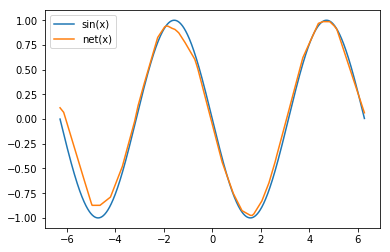

In [7]:
test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
test_y = torch.sin(test_x + t_b)

test_f, _, _ = net(test_x, t_params)

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.legend()
plt.savefig('daml-sine.png')

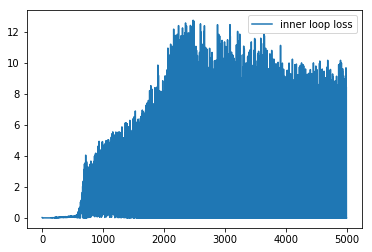

In [9]:
def plot_loss(inner_loop_loss,name="inner loop loss"):
    plt.plot(inner_loop_loss, label=name)
    plt.legend()

plot_loss(inner_loop_loss)


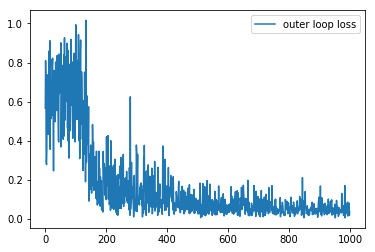

In [10]:
plot_loss(outer_lopp_loss, name = "outer loop loss")